In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from tensorflow.keras.applications import ResNet50

In [2]:
# Define folder paths
folder_path = r"C:\Users\padal\OneDrive\Desktop\my projects\Brain Tumour\archive\Brain_Tumor_Dataset"
negative_folder = 'Negative'
positive_folder = 'Positive'

In [3]:
negative_images = os.listdir(os.path.join(folder_path, negative_folder))
positive_images = os.listdir(os.path.join(folder_path, positive_folder))
dataset = []
labels = []

In [5]:
# Load 'Negative' images
for image_name in negative_images:
    image_path = os.path.join(folder_path, negative_folder, image_name)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    dataset.append(image)
    labels.append(0)

In [6]:
# Load 'Positive' images
for image_name in positive_images:
    image_path = os.path.join(folder_path, positive_folder, image_name)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    dataset.append(image)
    labels.append(1)

In [7]:
# Convert to NumPy arrays
X, y = np.array(dataset), np.array(labels)


In [8]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.05, random_state=True)

In [9]:
# Data augmentation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1
)


In [10]:
# Load pre-trained ResNet50 model
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the pre-trained weights

In [12]:
# Global average pooling layer
global_average_layer = GlobalAveragePooling2D()

In [13]:
# Prediction layer
prediction_layer = Dense(1, activation='sigmoid')

In [14]:
# Build the model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])


In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)


In [17]:
# Train the model with early stopping
history = model.fit(datagen_train.flow(X_train, Y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping])


Epoch 1/15


157/157 [==============================] - 217s 1s/step - loss: 0.2517 - accuracy: 0.9046 - val_loss: 0.1375 - val_accuracy: 0.9432
Epoch 2/15
157/157 [==============================] - 211s 1s/step - loss: 0.1181 - accuracy: 0.9590 - val_loss: 0.1189 - val_accuracy: 0.9545
Epoch 3/15
157/157 [==============================] - 199s 1s/step - loss: 0.0950 - accuracy: 0.9698 - val_loss: 0.0974 - val_accuracy: 0.9583
Epoch 4/15
157/157 [==============================] - 204s 1s/step - loss: 0.0795 - accuracy: 0.9762 - val_loss: 0.0833 - val_accuracy: 0.9659
Epoch 5/15
157/157 [==============================] - 211s 1s/step - loss: 0.0776 - accuracy: 0.9752 - val_loss: 0.0730 - val_accuracy: 0.9621
Epoch 6/15
157/157 [==============================] - 216s 1s/step - loss: 0.0644 - accuracy: 0.9796 - val_loss: 0.0658 - val_accuracy: 0.9773
Epoch 7/15
157/157 [==============================] - 212s 1s/step - loss: 0.0593 - accuracy: 0.9818 - val_loss: 0.0676 - val_accuracy: 0.96

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

9/9 [==============================] - 10s 1s/step - loss: 0.0346 - accuracy: 0.9886
Test Loss: 0.034587860107421875
Test Accuracy: 0.9886363744735718


In [19]:
# Make predictions
predictions = model.predict(X_test)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(Y_test, predicted_labels)
recall = recall_score(Y_test, predicted_labels)
f1 = f1_score(Y_test, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


9/9 [==============================] - 11s 1s/step
Precision: 1.0
Recall: 0.9820359281437125
F1 Score: 0.9909365558912386


In [20]:
# Get the model summary
model.summary()

# Save the model
model.save("Brain_Tumor_Detection_ResNet50.keras")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


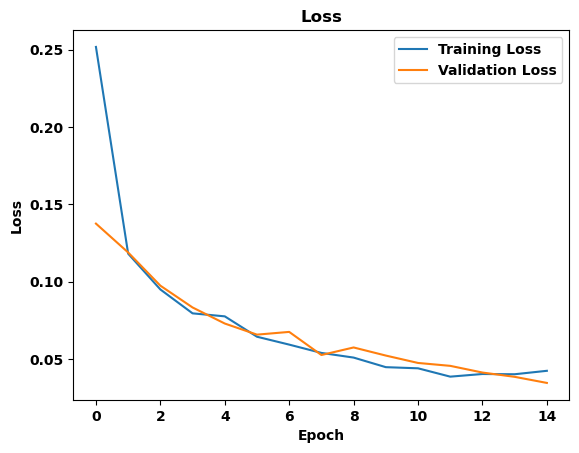

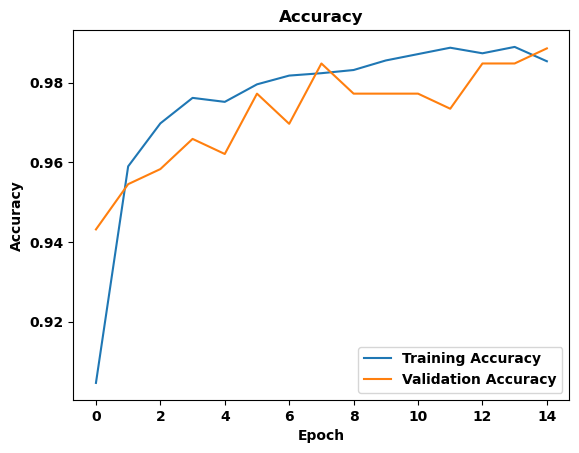

In [21]:
# Plot metrics
def plot_metrics(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss plot
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy plot
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

In [22]:
global_avg_pool_shape = tf.keras.layers.GlobalAveragePooling2D()(base_model.output).shape
print("Output shape of global_average_layer:", global_avg_pool_shape)
print("Input shape expected by dense layer:", prediction_layer.input_shape)


Output shape of global_average_layer: (None, 2048)
Input shape expected by dense layer: (None, 2048)


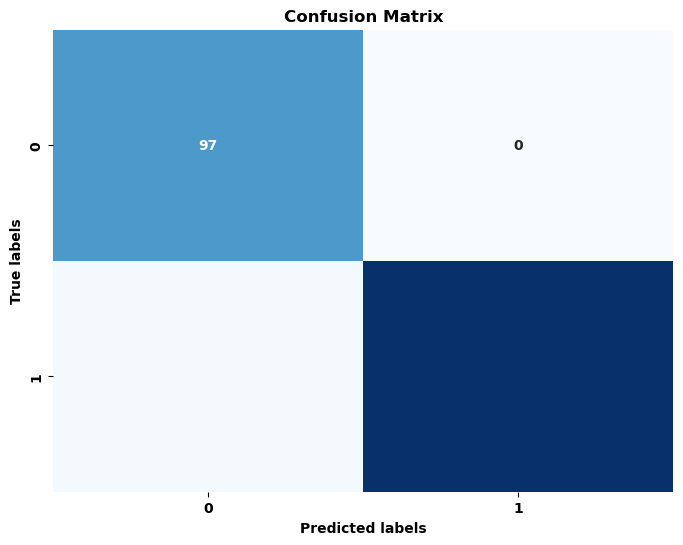

In [23]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(Y_test, predicted_labels)

In [25]:
#Additional evaluation metrics
# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, F1 score, and support
report = classification_report(Y_test, y_pred_binary)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred_binary)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(Y_test, y_pred)

# Display classification report, confusion matrix, and ROC-AUC score
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm)
print("\nROC-AUC Score:", roc_auc)

9/9 [==============================] - 9s 973ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        97
           1       1.00      0.98      0.99       167

    accuracy                           0.99       264
   macro avg       0.98      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264


Confusion Matrix:
[[ 97   0]
 [  3 164]]

ROC-AUC Score: 0.9993826779430829
